In [1]:
]activate ..

┌ Info: activating environment at `~/Downloads/957d862f9be66534a6ab1da674ff7e3c-168dc30267f5c72aa62bc3d09b30dec414004dbf/Project.toml`.
└ @ Pkg.API /Users/mike/projects/julia/release/usr/share/julia/stdlib/v1.2/Pkg/src/API.jl:564


# Computing key rate duration in Julia

This looks at the problem of computing bond price sensitivies (durations) with respect to _key rates_ via automatic differentiation (AD).

There are two steps to computing the price of a bond from the key rates:
1. Bootstrap a full yield curve from the key rates (specified as par rates with twice-yearly coupons).
2. Compute the price of the bond from the yield curve

To compute the duration, we need to do AD through both of these steps.

An additional complexity is that step 1 requires solving certain implicit problems (computing the appropriate discount rate so that the bond is redeemed at par): we solve these via Newton iterations using AD tools. Consequently we have a _nested AD problem_: computing derivatives of something that is already using derivatives. Fortunately Julia's flexible design makes this fairly straightforward.

In [2]:
using Dates

# par rate data from https://treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield
maturities = [Month(1),Month(2),Month(3),Month(6),Year(1),Year(2),Year(3),Year(5),Year(7),Year(10),Year(20),Year(30)]
parrates = [2.45,2.43,2.43,2.51,2.53,2.50,2.48,2.48,2.56,2.66,2.85,3.01] ./ 100;

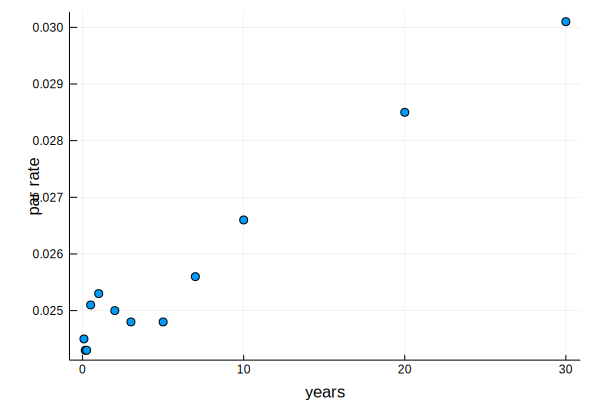

In [4]:
using Plots
gr()
plot(Dates.value.(maturities)/12, parrates, marker=:dot, line=false, xlabel="years",ylabel="par rate",legend=false)

We use forward-mode automatic differentiation via [Zygote.jl](https://github.com/FluxML/Zygote.jl).

In [5]:
using Zygote

# Define some simple utilities for solving implicit problems
function value_deriv(f, x)
    y, back = Zygote.forward(f, x)
    y, back(1)[1]
end

function newton_solve(f,target,x_init; atol=1e-8)
    x_prev = x_init
    while true
        Δ, Δ′ = value_deriv(x -> f(x)-target, x_prev)
        x = x_prev - Δ / Δ′
        if abs(x - x_prev) < atol
            return x
        end
        x_prev = x
    end
end

┌ Info: Recompiling stale cache file /Users/mike/.julia/compiled/v1.2/Zygote/4kbLI.ji for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1240


newton_solve (generic function with 1 method)

In [6]:
newton_solve(x -> x^2, 25, 1)

5.0

# 1. Yield curve interpolation

We define a Julia type to represent the interpolated yield curve. We assume that the continuously-compounded forward rates are piecewise constant (i.e. linear interpolating along the log-discount factor).

This is a fairly simple method of interpolation, but more complicated methods could be used.

In [7]:
struct PiecewiseConstantForwardCurve{D,T}
    dates::Vector{D} # n+1
    logindices::Vector{T} # n+1
    fwdrates::Vector{T} # n
end

# the current pricing date
refdate(c::PiecewiseConstantForwardCurve) = first(c.dates)

# Assume Actual/365 basis: more generally we can use
# use https://github.com/JuliaFinance/DayCounts.jl
yearfrac(d::Month) = d/Month(12)
yearfrac(d::Day) = d/Day(365)

# interpolate the logindex from the yield curve
# the extensionrate option is used for extending beyond the interpolation
# its main use is as part of the bootstrapping
function logindex(c::PiecewiseConstantForwardCurve, date; extensionrate=0.0)
    n = length(c.dates)
    i = searchsortedlast(c.dates, date)
    dt1 = c.dates[i:i]
    t = yearfrac.(date .- dt1)
    c.logindices[i:i] .+ t .* (i < n ? c.fwdrates[i:i] : extensionrate)
end

# compute the discount factor from yield curve
discount(c::PiecewiseConstantForwardCurve, date; extensionrate=0.0) = exp.(-logindex(c, date; extensionrate=extensionrate))

discount (generic function with 1 method)

We also define a Julia type to represent a bond, along with a function to compute the price of the bond under a given yield curve.

In [8]:
# A struct representing a simple bond paying coupons on a regular basis
struct Bond{CD,MD,T}
    couponfreq::CD
    couponamt::T
    maturitydate::MD
    maturityamt::T
end
Bond(couponfreq, couponamt, maturitydate) = Bond(couponfreq, couponamt, maturitydate, one(couponamt))

# calculate the price of a bond (the discounted present value less accrued interest)
function price(c::PiecewiseConstantForwardCurve, b::Bond; extensionrate=0.0, clean=true)
    coupondate = b.maturitydate
    v = (b.couponamt + b.maturityamt) .* discount(c, coupondate; extensionrate=extensionrate)
    while true
        coupondate -= b.couponfreq
        if coupondate ≤ refdate(c)
            break
        end
        v = v .+ b.couponamt .* discount(c, coupondate; extensionrate=extensionrate)
    end
    if clean
        accruedinterest = b.couponamt * yearfrac(refdate(c) - coupondate) / yearfrac(b.couponfreq)
        return v .- accruedinterest
    else
        return v
    end
end


price (generic function with 1 method)

Using the above functionality, we can bootstrap the yield curve from the par rates.

In [12]:
# given a yield curve, find the next forward rate that matches the current bond price
function solve_extensionrate(c::PiecewiseConstantForwardCurve, b::Bond, bondprice, extensionrate_init=0.0, tol=1e-6)
    newton_solve(r -> sum(price(c, b, extensionrate=r)), bondprice, extensionrate_init)
end

# bootstrap a yield curve from a set of par rates
function bootstrap_from_par(maturities, parrates, couponfreq=Month(6))
    #@assert length(maturities) == length(parrates)
    n = length(maturities)

    z = zero(eltype(parrates))
    c = PiecewiseConstantForwardCurve([zero(eltype(maturities))], 
        fill(z, 1), fill(z, 0))

    for (maturity, parrate) in zip(maturities, parrates)
        fwdrate = solve_extensionrate(c, Bond(couponfreq, parrate*yearfrac(couponfreq), maturity), 1, parrate)
        append!(c.logindices, c.logindices[end:end] .+ yearfrac.(maturity .- c.dates[end:end]).*fwdrate)
        append!(c.dates, [maturity])
        append!(c.fwdrates, [fwdrate])
    end
    c
end

bootstrap_from_par (generic function with 2 methods)

In [13]:
yieldcurve = bootstrap_from_par(maturities, parrates)

PiecewiseConstantForwardCurve{Month,Float64}(Month[Month(0), Month(1), Month(2), Month(3), Month(6), Month(12), Month(24), Month(36), Month(60), Month(84), Month(120), Month(240), Month(360)], [0.0, 0.0020189957207636033, 0.0040094101476904455, 0.006020159642918327, 0.012471901495320403, 0.025142563669506006, 0.04968386173221466, 0.07392142347542628, 0.12321642223075407, 0.17841176975803347, 0.2656003953884089, 0.5736592316137046, 0.9235812345168846], [0.02422794864916324, 0.023884973123122107, 0.024128993942734576, 0.025806967409608302, 0.02534132434837121, 0.02454129806270865, 0.024237561743211625, 0.0246474993776639, 0.0275976737636397, 0.029062875210125152, 0.030805883622529572, 0.034992200290318])

We can now plot the results of the interpolation

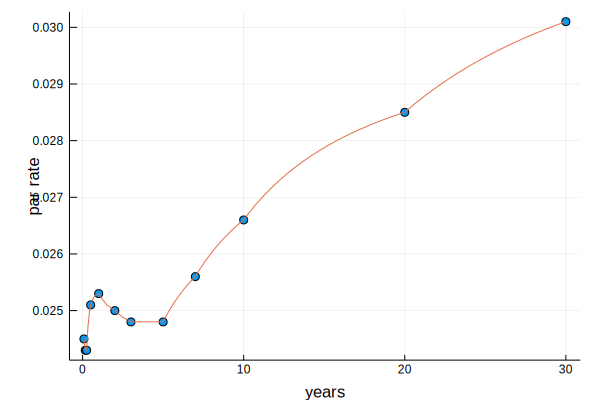

In [14]:
# compute par rate from yield curve
function parrate(c::PiecewiseConstantForwardCurve, maturity, couponfreq=Month(6))
    newton_solve(parrate -> sum(price(c, Bond(couponfreq, parrate*yearfrac(couponfreq), maturity))), 1.0, 0.0)
end

# interpolate par rates
xmaturities = Month.(1:360)
xparrates = [parrate(yieldcurve, d) for d in xmaturities]
plot(Dates.value.(maturities)/12, parrates,
    marker=:dot, line=false, xlabel="years",ylabel="par rate",legend=false)
plot!(Dates.value.(xmaturities)/12, xparrates)

# 2. Key rate durations

The key rate durations are the relative derivatives of the negative bond price wrt to the key rates used to bootstrap the yield curve.

$$ \text{duration}_i = -\frac{\partial\,\text{price}}{\partial\,\text{par rate}_i} \frac{1}{\text{price}}$$

(note this should be the "dirty" price, since that is the value which is actually changing)

For this we use `ForwardDiff.jacobian`:

In [15]:
# compute the price sensitivies of each bond wrt to the key par rates
function keyrate_durations(keyparrates, keydurations, bondlist)
    function pricefun(keyparrates)
        yieldcurve = bootstrap_from_par(keydurations, keyparrates)
        map(bond->sum(price(yieldcurve, bond; clean=false)), bondlist)
    end
    _, grads = Zygote.forward_jacobian(pricefun, keyparrates)
    value = pricefun(keyparrates)
    -grads' ./ value
end

keyrate_durations (generic function with 1 method)

In [28]:
# a hypothetical list of bonds
bondlist = [Bond(Month(3), 0.05, Month(1)),
            Bond(Month(3), 0.05, Month(2)),
            Bond(Month(3), 0.05, Month(4)),
            Bond(Month(3), 0.05, Month(12)),
            Bond(Month(6), 0.03, Month(14)),
            Bond(Month(6), 0.04, Month(19)),
            Bond(Month(6), 0.02, Month(28)),
            Bond(Month(6), 0.035, Month(54)),
            Bond(Month(6), 0.04, Month(220)),
            Bond(Month(6), 0.03, Month(356))]

D = keyrate_durations(parrates, maturities, bondlist)

10×12 Array{Float64,2}:
  0.0814929     0.0          0.0         …  0.0       0.0       0.0   
 -1.67921e-15   0.163343     0.0            0.0       0.0       0.0   
  0.00372604   -1.58919e-16  0.156188       0.0       0.0       0.0   
  1.08713e-31  -1.05923e-17  0.0104103      0.0       0.0       0.0   
 -4.73477e-17   0.00460568   0.0            0.0       0.0       0.0   
  0.00290971    0.0          0.0         …  0.0       0.0       0.0   
  3.25821e-32  -3.17459e-18  0.00312004     0.0       0.0       0.0   
  0.0           0.0          0.0            0.0       0.0       0.0   
  3.86326e-32  -3.76411e-18  0.00369943     2.04168   9.09089   0.0   
 -3.10566e-17   0.00302099   0.0            0.609989  2.35106  13.8108

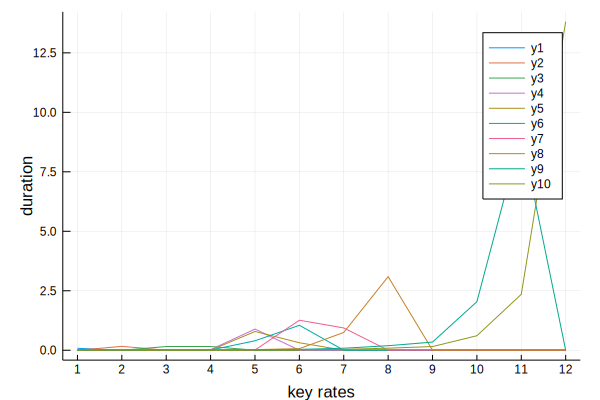

In [35]:
# plot the key rate durations of each bond DiffResults.jacobian(result) ./ DiffResults.value(result)
plot(D', xticks=1:12, xlabel="key rates", ylabel="duration")

This is not really optimised code, but still quite fast.

In [18]:
using BenchmarkTools
@time keyrate_durations(parrates, maturities, bondlist);

  0.184786 seconds (752.97 k allocations: 31.152 MiB, 13.32% gc time)


This should scale linearly with the number of bonds, so ~50k bonds per second.

# 3. Check the results

As a check, we can confirm that the key rate durations of the bonds used to bootstrap the curve depend only the relevant rate:

In [19]:
refbonds = Bond.(Month(6), parrates./2, maturities)
refD = keyrate_durations(parrates, maturities, refbonds)

12×12 Array{Float64,2}:
  0.0814929     0.0        0.0       …   0.0           0.0           0.0   
 -1.67921e-15   0.163343   0.0           0.0           0.0           0.0   
  2.5638e-30   -2.498e-16  0.245508      0.0           0.0           0.0   
  0.0           0.0        0.0           0.0           0.0           0.0   
  0.0           0.0        0.0           0.0           0.0           0.0   
  0.0           0.0        0.0       …   0.0           0.0           0.0   
  0.0           0.0        0.0           0.0           0.0           0.0   
  0.0           0.0        0.0           0.0           0.0           0.0   
  0.0           0.0        0.0           0.0           0.0           0.0   
  0.0           0.0        0.0           8.76897       0.0           0.0   
  0.0           0.0        0.0       …   1.28367e-12  15.3172        0.0   
  0.0           0.0        0.0          -6.76542e-16   6.64399e-16  20.0301

In [20]:
# check that off-diagonal elements are zero (up to round-off error)
using LinearAlgebra
isapprox(refD, Diagonal(diag(refD)))

true

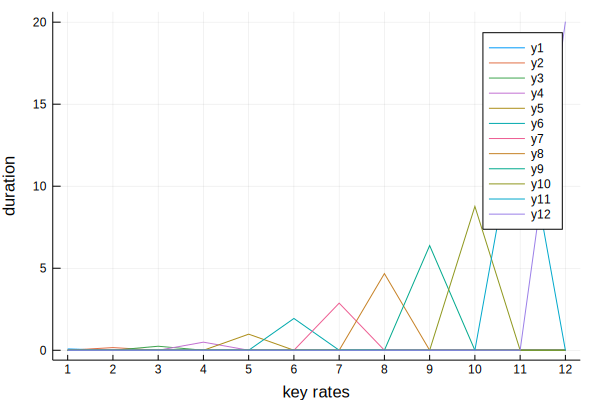

In [21]:
plot(refD', xticks=1:12, xlabel="key rates", ylabel="duration")